<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session5/EVA7_Session_5_Drill_Down_Part_4_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Target
1. Add dropout to all convolution layers (except last one) to reduce overfitting. Reduction in accuracy is expected.

# Results

Total parameters: 7,624

Best Training Accuracy: 98.93% - 14th Epoch

Best Testing Accuracy: 99.22% - 13th Epoch

# Analysis

Overfitting is no longer present, and slight underfitting is present, considering training accuracy is below testing accuracy for the last few epochs consistently.

Overall accuracy has reduced which is expected considering dropout has been added.

Next step should be to add augmentations to improve accuracy.

## Specify Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Download Dataset & Specify Transformations

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Device & Dataloader Specifications

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Model

In [5]:
dropout_value = 0.05


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2,2), ## Squeeze
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False), ## Pointwise Convolution
        ) # output_size = 12
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8) ## Global Average Pooling
        ) # output_size = 1

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), ## Increase (expand) number of channels
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), ## Reduce down number of channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), ## Reduce number of channels to output required
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Define Train & Test Functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Train & Test Model

In [8]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, steps_per_epoch=10, epochs=20)

## Unsuccesful - only training accuracy reached 99.4, testing accuracy did not
# lmbda = lambda epoch: 0.65 ** epoch
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

## Unstable - touched 99.4% at the 20th Epoch, but not stable
# lambda1 = lambda epoch: 0.75 ** epoch

## Failure - did not reach target
# lambda1 = lambda epoch: 0.5 ** epoch

## Reached stable 99.4% starting from Epoch 17
# lambda1 = lambda epoch: 0.65 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

#scheduler = ExponentialLR(optimizer, gamma=0.1) - reached 99.4% couple of times, but didn't stabilize
#scheduler = StepLR(optimizer, step_size=3, gamma=0.1) - reached goal post 15 epochs, 18th, 19th and 20th Epochs

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.5280151963233948 Batch_id=937 Accuracy=92.89: 100%|██████████| 938/938 [00:54<00:00, 17.20it/s]



Test set: Average loss: 0.0614, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.09533973038196564 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:53<00:00, 17.43it/s]



Test set: Average loss: 0.0453, Accuracy: 9852/10000 (98.52%)

EPOCH: 3


Loss=0.019751915708184242 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:54<00:00, 17.19it/s]



Test set: Average loss: 0.0392, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.003469838760793209 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:54<00:00, 17.21it/s]



Test set: Average loss: 0.0386, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.0525018572807312 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:54<00:00, 17.32it/s]



Test set: Average loss: 0.0349, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.004780890420079231 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:54<00:00, 17.26it/s]



Test set: Average loss: 0.0363, Accuracy: 9880/10000 (98.80%)

EPOCH: 7


Loss=0.0021606539376080036 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s]



Test set: Average loss: 0.0320, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.07380407303571701 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:53<00:00, 17.38it/s]



Test set: Average loss: 0.0315, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.04202430695295334 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s]



Test set: Average loss: 0.0318, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.004502046387642622 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:54<00:00, 17.24it/s]



Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.03137052804231644 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:54<00:00, 17.28it/s]



Test set: Average loss: 0.0273, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.008610443212091923 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:54<00:00, 17.20it/s]



Test set: Average loss: 0.0343, Accuracy: 9884/10000 (98.84%)

EPOCH: 13


Loss=0.01170253288000822 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:54<00:00, 17.25it/s]



Test set: Average loss: 0.0274, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.02472359873354435 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:54<00:00, 17.24it/s]



Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.06043858081102371 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:54<00:00, 17.28it/s]



Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)



## Training & Testing Loss Curves

Text(0.5, 1.0, 'Test Accuracy')

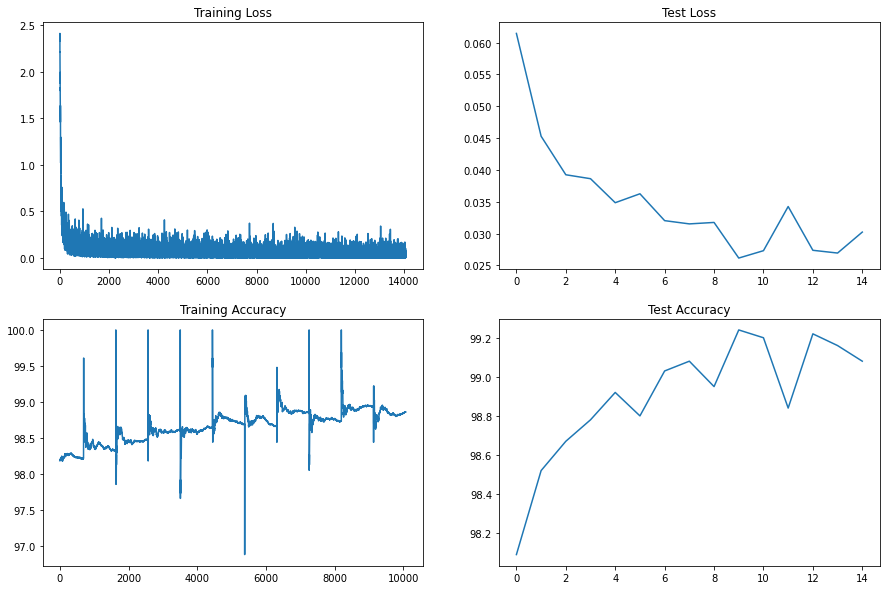

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Visualize Incorrect Predictions

In [10]:
def get_incorrect_preds(test_loader,model,device):
  incorrect_images = []
  incorrect_label = []
  correct_label = []
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True) 

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      incorrect_images.append(data[wrong_pred])
      incorrect_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])   

  return list(zip(torch.cat(incorrect_images),torch.cat(incorrect_label),torch.cat(correct_label)))

wrong_predictions = get_incorrect_preds(test_loader,model,device)
print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 92


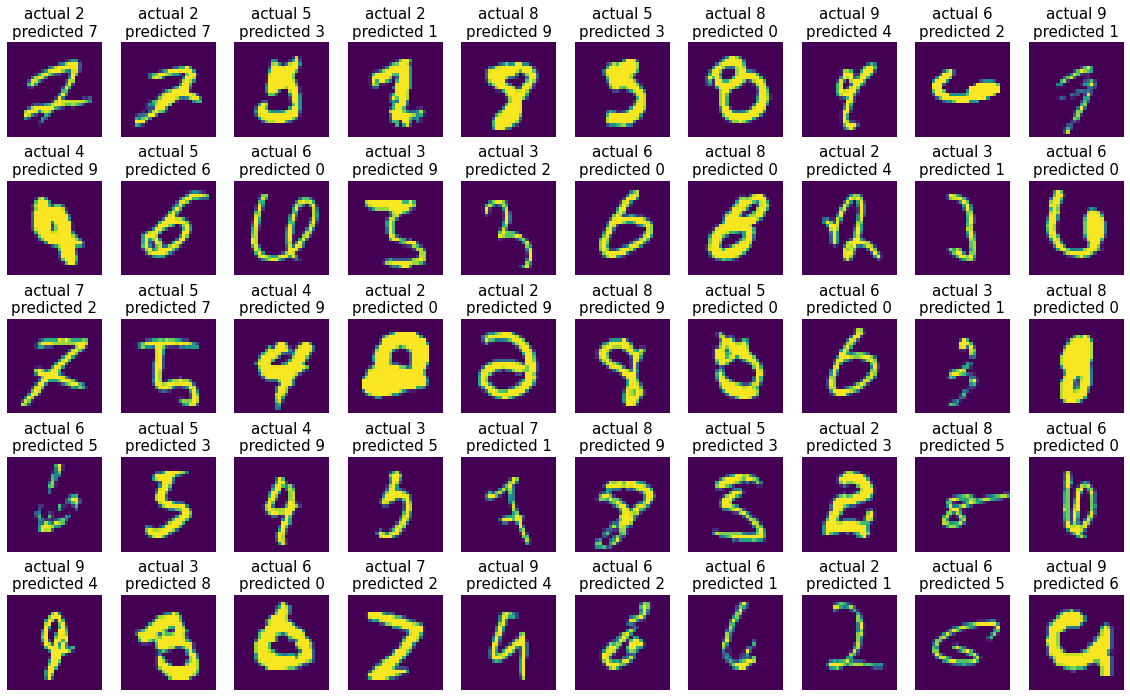

In [11]:
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(wrong_predictions[:50]):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()